Exercise 1: total responses = 15, A = 5, B = 10
Exercise 1: <s> = 35.294, sigma(s) = 11.264


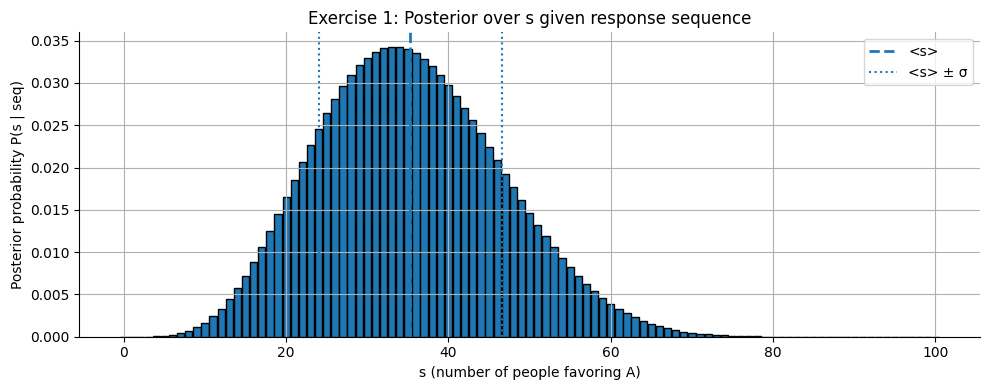

In [3]:
# @title
# --- Exercise 1: 離散化的 Bayes 更新 ---

N_pop = 100
seq = ['B','B','B','A','B','A','B','A','A','B','A','B','B','B','B']

# 計數
n_total = len(seq)
n_A = seq.count('A')
n_B = seq.count('B')
print(f'Exercise 1: total responses = {n_total}, A = {n_A}, B = {n_B}')

# s 的可能值 0..N
s_vals = np.arange(N_pop + 1)
prior = np.ones_like(s_vals, dtype=float) / (N_pop + 1)  # 均勻先驗

# 對每個 s 計算 P(seq | s)（使用 log space 避免 underflow）
p_A = s_vals / N_pop
p_B = 1.0 - p_A
with np.errstate(divide='ignore'):
    log_like = n_A * np.log(p_A) + n_B * np.log(p_B)

# 將 -inf（log(0)）替換成非常小的值，對應 likelihood ~ 0
log_like = np.where(np.isfinite(log_like), log_like, -1e9)

# 平移 log-likelihood 以避免 overflow/underflow
log_like -= log_like.max()
like = np.exp(log_like)

posterior_unnorm = like * prior
posterior = posterior_unnorm / posterior_unnorm.sum()

# 後驗平均與標準差
E_s = np.sum(s_vals * posterior)
Var_s = np.sum((s_vals - E_s)**2 * posterior)
Std_s = np.sqrt(Var_s)
print(f'Exercise 1: <s> = {E_s:.3f}, sigma(s) = {Std_s:.3f}')

# 畫 posterior
plt.figure(figsize=(10, 4))
plt.bar(s_vals, posterior, width=0.9, edgecolor='k')
plt.axvline(E_s, color='C0', lw=2, ls='--', label=r'<s>')
plt.axvline(E_s - Std_s, color='C0', lw=1.5, ls=':', label=r'<s> ± σ')
plt.axvline(E_s + Std_s, color='C0', lw=1.5, ls=':')
plt.title('Exercise 1: Posterior over s given response sequence')
plt.xlabel('s (number of people favoring A)')
plt.ylabel('Posterior probability P(s | seq)')
plt.legend()
plt.tight_layout()
plt.show()


Exercise 2: r keys (sorted) = [0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
Exercise 2: r values (unique, sorted) = [0.0625 0.125  0.25   0.5    1.     2.     4.    ]
Global response range: [0.102, 47.129]


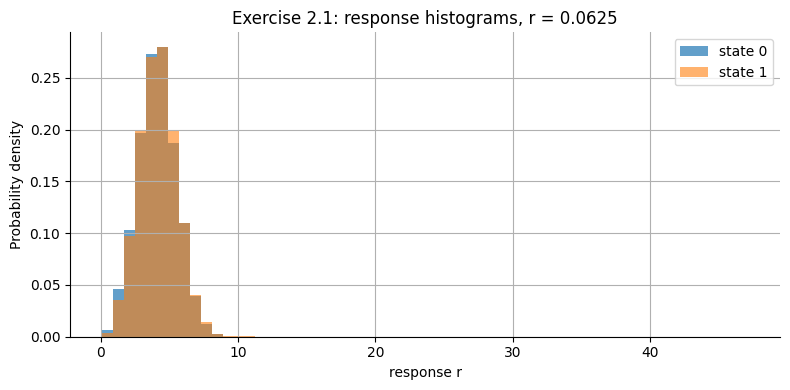

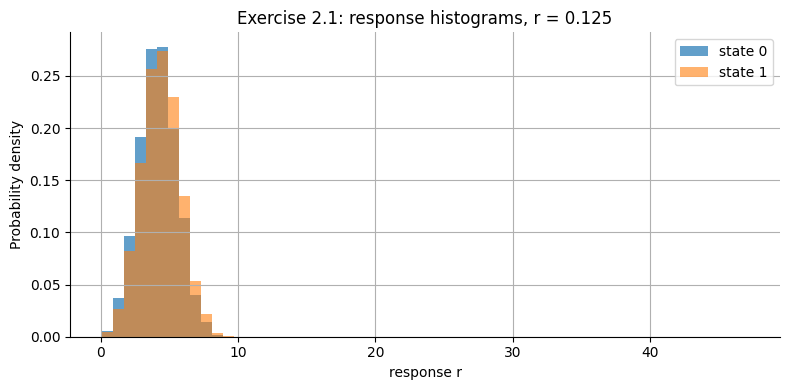

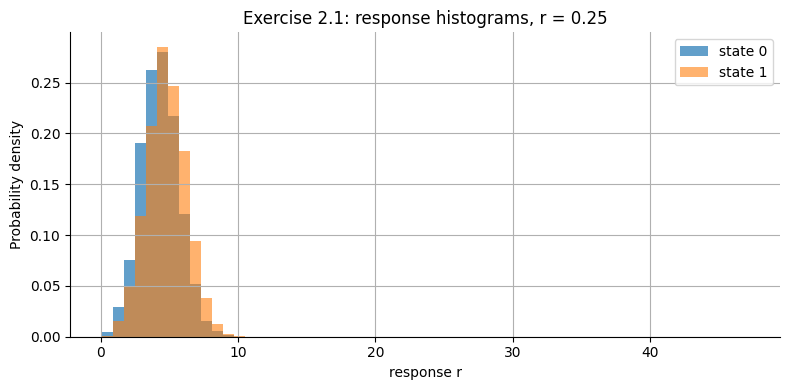

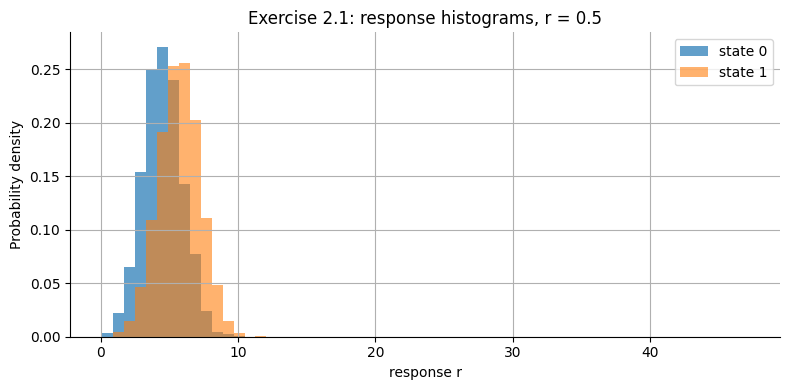

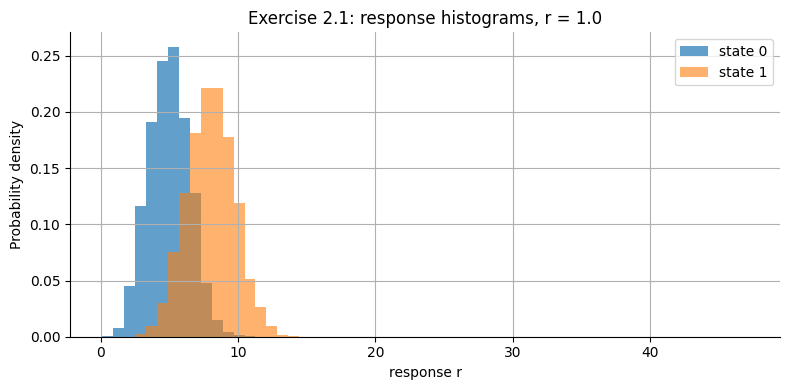

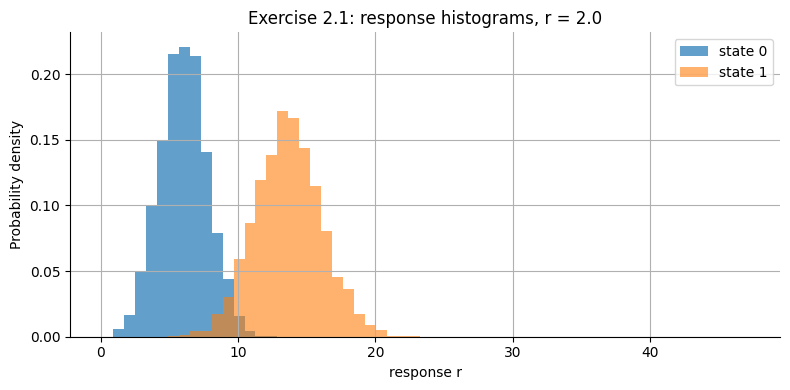

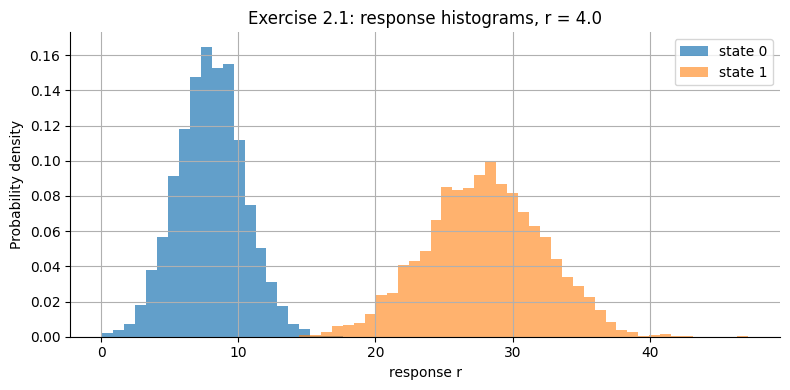

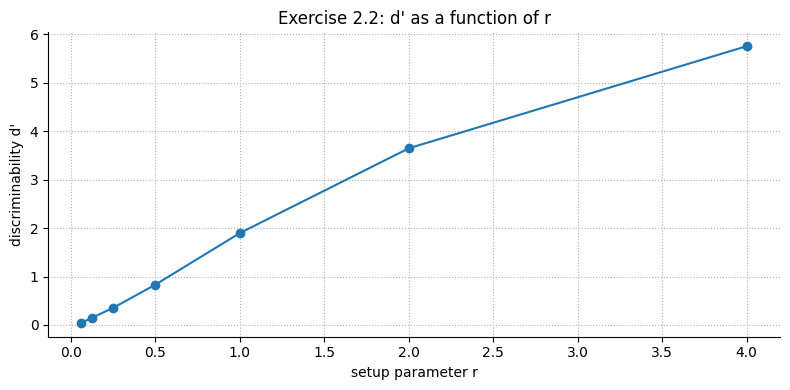

r = 0.0625: d' = 0.042
r = 0.125: d' = 0.148
r =  0.25: d' = 0.352
r =   0.5: d' = 0.831
r =     1: d' = 1.897
r =     2: d' = 3.648
r =     4: d' = 5.758


In [4]:
# @title
# --- Exercise 2: 讀取資料、畫直方圖、計算 d' ---

data = np.load('hw09-data.npz', allow_pickle=True)
dat = data['dat'].item()  # 取出內部字典

# r 的 key 可能是字串，這裡依照 float 值排序
r_keys_sorted = sorted(list(dat.keys()), key=lambda k: float(k))
r_vals_unique = np.array(sorted({float(k) for k in dat.keys()}))
print('Exercise 2: r keys (sorted) =', r_keys_sorted)
print('Exercise 2: r values (unique, sorted) =', r_vals_unique)

# 決定共享的 histogram 範圍
all_responses = []
for k in r_keys_sorted:
    arr = np.asarray(dat[k])  # shape (2, 4096)
    all_responses.append(arr[0].ravel())
    all_responses.append(arr[1].ravel())
all_responses = np.concatenate(all_responses)
vmin, vmax = float(all_responses.min()), float(all_responses.max())
print(f'Global response range: [{vmin:.3f}, {vmax:.3f}]')

bins = np.linspace(vmin, vmax, 60)

dprime_by_r = {}

for k in r_keys_sorted:
    arr = np.asarray(dat[k])  # (2, 4096)
    s0 = arr[0]
    s1 = arr[1]

    # 直方圖
    plt.figure(figsize=(8, 4))
    plt.hist(s0, bins=bins, density=True, alpha=0.7, label='state 0')
    plt.hist(s1, bins=bins, density=True, alpha=0.6, label='state 1')
    plt.title(f'Exercise 2.1: response histograms, r = {float(k)}')
    plt.xlabel('response r')
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # d' 計算
    mu0, mu1 = s0.mean(), s1.mean()
    sd0, sd1 = s0.std(ddof=1), s1.std(ddof=1)
    sigma = np.sqrt((sd0**2 + sd1**2) / 2.0)
    dprime = abs(mu1 - mu0) / sigma
    dprime_by_r[float(k)] = float(dprime)

# 畫 d'(r)
r_plot = np.array(sorted(dprime_by_r.keys()))
d_plot = np.array([dprime_by_r[r] for r in r_plot])

plt.figure(figsize=(8, 4))
plt.plot(r_plot, d_plot, marker='o')
plt.title("Exercise 2.2: d' as a function of r")
plt.xlabel('setup parameter r')
plt.ylabel("discriminability d'")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

for r in r_plot:
    print(f"r = {r:>5.4g}: d' = {dprime_by_r[r]:.3f}")
